In [1]:
from utils import set_working_directory_up_two_levels
set_working_directory_up_two_levels()

In [2]:
import tensorflow as tf
import pandas as pd 
import numpy as np
import toml 
import os

import matplotlib.pyplot as plt 
from src.data.record import DataPipeline
from presentation.pipelines.steps.model_design import load_pt_model, build_model
from presentation.pipelines.steps.load_data import build_loader 
from sklearn.metrics import r2_score, mean_squared_error
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

2024-12-20 17:40:05.051344: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-20 17:40:05.051391: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-20 17:40:05.051417: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-20 17:40:05.060007: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
model = build_model(params={
'num_layers': 12,
'num_heads': 6,
'head_dim': 6,
'mixer': 1024,
'dropout': 0.1,
'pe_base': 1000,
'pe_dim': 256,
'pe_exp': 2,
'window_size': 300,
'm_alpha': 0,
'mask_format': 'K',
'use_leak': True,
'loss_format': 'rmse',
'correct_loss': True,
'no_msk_token': False,
'temperature': 0,
    'arch': 'base'
})

[INFO] Loading BASE
[INFO] Temperature: 0.00
[INFO] Mask format: K
[INFO] Adding trainable MSK token


2024-12-20 17:40:09.359960: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-12-20 17:40:09.360072: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: pececillo
2024-12-20 17:40:09.360078: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: pececillo
2024-12-20 17:40:09.360278: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.104.5
2024-12-20 17:40:09.360330: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.104.5
2024-12-20 17:40:09.360334: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.104.5


In [19]:
model.summary()

Model: "ASTROMER-1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 300, 1)]             0         []                            
                                                                                                  
 input_14 (InputLayer)       [(None, 300, 1)]             0         []                            
                                                                                                  
 input_15 (InputLayer)       [(None, 300, 1)]             0         []                            
                                                                                                  
 encoder (Encoder)           (None, 300, 36)              1027280   ['input_13[0][0]',            
                                                                     'input_14[0][0]',   

In [21]:
root = './presentation/results/diagstromer/2024-12-02_14-13-12/pretraining/'
model, config = load_pt_model(root)

[INFO] Loading BASE
[INFO] Temperature: 0.00
[INFO] Mask format: K
[INFO] Adding trainable MSK token


In [64]:
loaders = build_loader('./data/records/alcock/all/fold_2/', 
                       config, 
                       batch_size=16, 
                       clf_mode=False, 
                       normalize='zero-mean', 
                       sampling=False,
                       repeat=1,
                       shuffle=True,
                       cache=False,
                       return_test=True,
                      probed=1.,
                      random=0.,
                      same=0.,)

[INFO] String based loader
[INFO] Probed: 1.00 Random: 0.00 Same: 0.00
[INFO] Normalization:  zero-mean
[INFO] Probed: 1.00 Random: 0.00 Same: 0.00
[INFO] Normalization:  zero-mean
[INFO] Probed: 1.00 Random: 0.00 Same: 0.00
[INFO] Normalization:  zero-mean


In [65]:
from astropy.timeseries import LombScargle

def fold_curve(times, magnitudes):
    frequency, power = LombScargle(times, magnitudes).autopower()
    period = 1/frequency[np.argmax(power)]
    phase = (times % period)/period
    indices = np.argsort(phase)
    return indices, phase

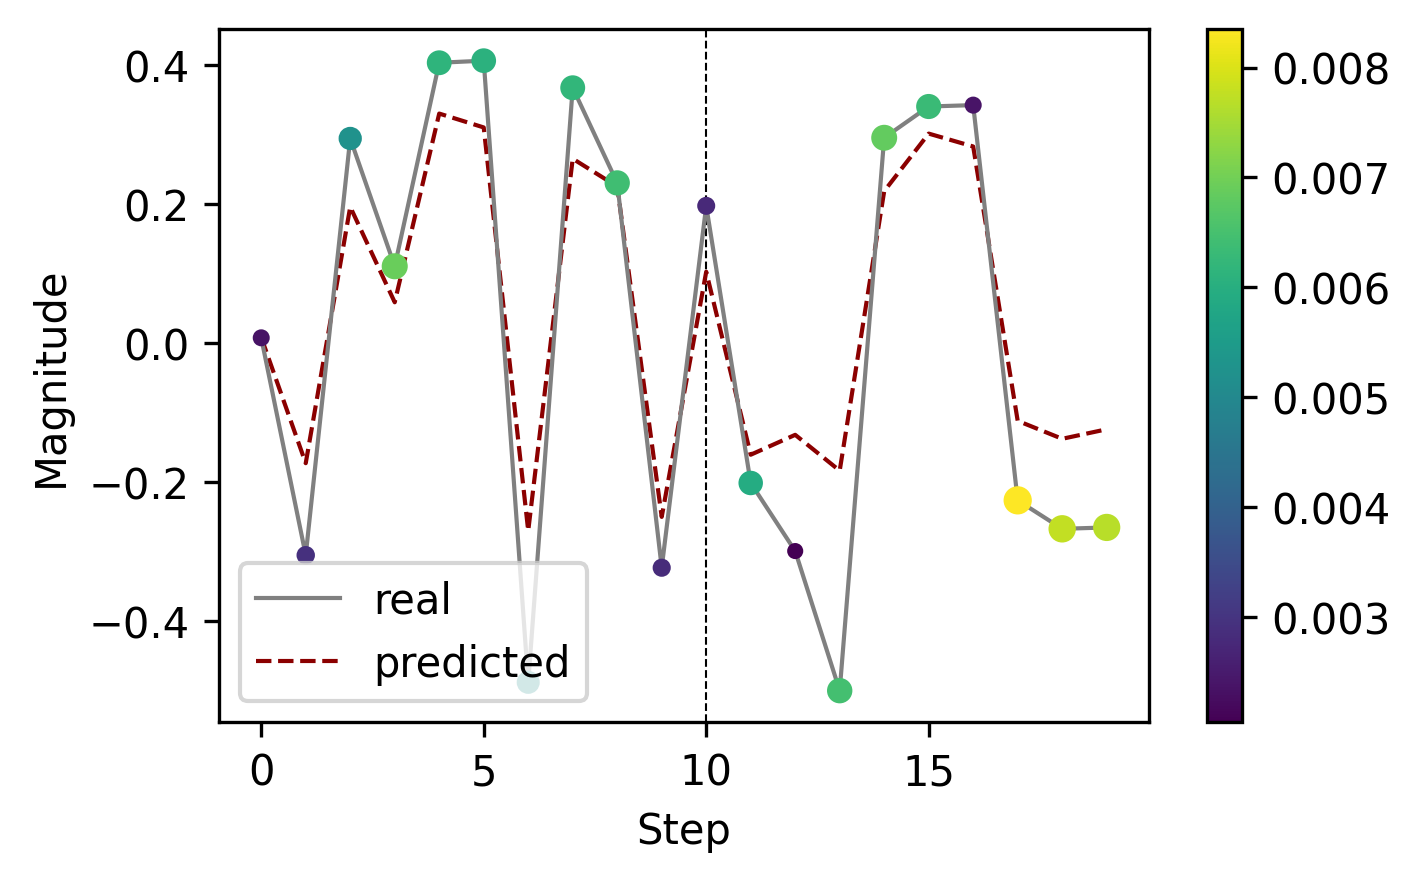

In [116]:
plt.figure( figsize=(5, 3), dpi=300)
for idx, (x, y) in enumerate(loaders['train'].take(1)):

    z, watt, q = model.get_layer('encoder')(x, return_weights=True)
    y_pred = model(x)

    valid = y['target'][N] * x['mask_in'][N]

    tmasked = tf.boolean_mask(x['times'][N], 1.-x['mask_in'][N])
    xmasked = tf.boolean_mask(x['input'][N], 1.-x['mask_in'][N])
    pmasked = tf.boolean_mask(y_pred[N], 1.-x['mask_in'][N])
    
    mean_attention = tf.boolean_mask(watt[N, 0], 1.-x['mask_in'][N,...,0])
    mean_attention = tf.boolean_mask(tf.transpose(mean_attention), 1.-x['mask_in'][N,...,0])
    mean_attention = tf.transpose(mean_attention)
    
    r2value = r2_score(tmasked.numpy(), pmasked.numpy())
    msevalue = mean_squared_error(tmasked.numpy(), pmasked.numpy())
    
    indices, phase = fold_curve(tmasked, xmasked)

    D=20
    tmasked = tmasked.numpy()[indices][:D]
    xmasked = xmasked.numpy()[indices][:D]
    pmasked = pmasked.numpy()[indices][:D]
    mean_attention = mean_attention.numpy()[indices][:, :D]

        
    plt.plot(xmasked, linestyle='-', color='gray', label='real', linewidth=1, zorder=3)
    plt.plot(pmasked, linestyle='--', color='darkred', label='predicted', linewidth=1, zorder=2)
    plt.scatter(range(mean_attention.shape[1]), xmasked, c=mean_attention[10], s=mean_attention[10]*4000, zorder=4)
    
    plt.xlabel('Step')
    plt.ylabel('Magnitude')
    plt.legend()
    plt.axvline(x=10, linestyle='--', color='k', linewidth=0.5, zorder=1)
    
plt.colorbar()
plt.show()


In [72]:
mean_attention

array([], shape=(200, 0), dtype=float32)